# HALHF Transverse Wake Instability Stages (Slice Version) Tests

For simulating the HALHF linac with interstages. The simulation employs the slice version of transverse wake instability model.

Ben Chen, 7 September 2023, University of Oslo

## Import ABEL framework and required classes

In [1]:
import sys
sys.path.append('../')
from abel import *
import numpy as np

from scipy.constants import c, e, m_e, epsilon_0 as eps0
from abel.utilities.relativity import energy2gamma

# Enable the widget backend for interactive plots
%matplotlib widget

# Sets the seed for the pseudo-random number generator in Python to obtain the same sequence of random numbers.
np.random.seed(42) 

[INFO    ] csr.py: module PYFFTW is not installed. Install it to speed up calculation.
[INFO    ] csr.py: module NUMEXPR is not installed. Install it to speed up calculation


initializing ocelot...
import: module PYFFTW is not installed. Install it to speed up calculation
import: module NUMEXPR is not installed. Install it to speed up calculation


## Settings and definitions

In [2]:
# Determines whether the results of the tracking should be overwritten.
overwrite = False

# Determines whether to use interstages in the tracking. Currently also need to comment out some lines in interstage_basic.py.
use_interstages = True

# Specifies the region of interest in units of main beam sigma_z (rms bunch length).
main_beam_roi = 3.0

# Number of stages in the linac.
num_stages = 16

# Set the default DPI
plt.rcParams['figure.dpi'] = 100

# Set the figure size to fit within the notebook cell
#plt.rcParams['figure.figsize'] = [.1, .1]  # Adjust these values as needed

# Set various paths
notebook_name = 'HALHF_slice_instability_stage_tests'
path_sep = os.sep
#upload_dir = '/scratch/project_465000445/jianbinb/uploaded/'
current_dir = os.path.abspath('')  # Get the current file's directory name.

# Labels for plots
zlab = '$z$ [$\mathrm{\mu}$m]'
xilab = r'$\xi$ [$\mathrm{\mu}$m]'
slab = '$s$ [m]'
xlab = '$x$ [$\mathrm{\mu}$m]'
field_lab = '$E_z$ [GV/m]'
dN_dz_lab = '$\partial N/\partial z$ [$\mathrm{m}^{-1}$]'
xps_lab = '$x\'$ [mrad]'
energ_lab = '$\mathcal{E}$ [GeV]'

## Define the input beams
Parameters based on "A hybrid, asymmetric, linear Higgs factory based on plasma-wakefield and radio-frequency acceleration" 23 Aug 2023.

In [3]:
# Define drive beam
driver = SourceBasic()
driver.num_particles = 50000
driver.charge = -e * 2.7e10  # [C]
driver.energy = 31.25e9  # [eV]
driver_gamma = energy2gamma(driver.energy)
driver.rel_energy_spread = 0.01*0
driver.bunch_length = 42.0e-6  # [m]
driver.z_offset = 334.0e-6  # [m]
driver.emit_nx, driver.emit_ny = 10.0e-6, 10.0e-6  # [m rad]
driver.beta_x, driver.beta_y = 30.0e-3, 30.0e-3 # [m]
#driver.wallplug_efficiency = 0.19

# Define main beam
main = SourceBasic()
main.num_particles = int(50000*2)
main.charge = -e * 1.0e10  # [C]
main.energy = 5e9  # [eV]
main_gamma = energy2gamma(main.energy)
main.rel_energy_spread = 0.005  # Relative rms energy spread.
main.bunch_length = 18.0e-06  # [m]
main.emit_nx, main.emit_ny = 160.0e-6, 0.56e-6  # [m rad]
main.beta_x = beta_matched(7.0e21, main.energy)  # [m]
main.beta_y = beta_matched(7.0e21, main.energy)  # [m]
main_sigma_x = np.sqrt(main.emit_nx/main_gamma*main.beta_x)  # [m]
main_sigma_y = np.sqrt(main.emit_ny/main_gamma*main.beta_y)  # [m]
main.x_offset = main_sigma_x*0.1  # [m]
main.y_offset = main_sigma_y*0.1  # [m]
#main.z_offset = 0.0  # [m]
main.z_offset = 9.7e-6  # [m]
main.symmetrize = True
#main.wallplug_efficiency = 0.1
#main.accel_gradient = 6.4e9  # [V/m]

## Define the linac

/Users/ben_c/Library/CloudStorage/OneDrive-UniversitetetiOslo/Software/opal_env/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/ben_c/Library/CloudStorage/OneDrive-UniversitetetiOslo/Software/opal_env/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


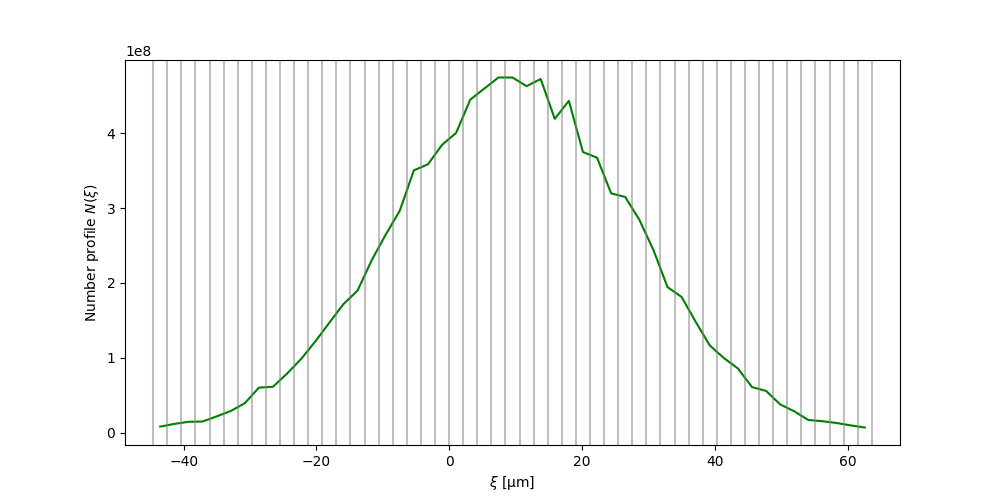

In [4]:
############# Define the first stage #############
first_stage = StageSlicesTransWakeInstability()
first_stage.length = 2.5  # [m]
first_stage.nom_energy_gain = 6.4e9*first_stage.length  # [eV]
first_stage.plasma_density = 7.0e21  # [m^-3]
first_stage.driver_source = driver
first_stage.main_source = main
drive_beam = first_stage.driver_source.track()  # Convert a Source object to a Beam object.
main_beam = first_stage.main_source.track()  # Convert a Source object to a Beam object.
first_stage.drive_beam = drive_beam
first_stage.main_beam = main_beam
first_stage.diag_path = current_dir + path_sep + 'run_data' + path_sep + notebook_name + path_sep


# ========== Beam slice parameters ========== 
first_stage.main_beam_roi = main_beam_roi
cut_off = first_stage.main_beam_roi*main.bunch_length
first_stage.beam_length_roi = 2*cut_off  # [m] total bunch/beam length.  old name: tot_beam_length

# Option: manually determine the beam slice thickness
beam_slice_thickness = 0.0196*first_stage.beam_length_roi   # [m] thickness of each beam slice.
num_uniform_beam_slice = int(np.round(first_stage.beam_length_roi / beam_slice_thickness))

# Option: sqrt rule for determining the beam slice thickness
#z0s_main = main_beam.zs()
#bool_indices = (z0s_main <= np.mean(z0s_main) + cut_off) & (z0s_main >= np.mean(z0s_main) - cut_off)
#z0s_filtered = z0s_main[bool_indices]
#num_uniform_beam_slice = int(np.sqrt(len(z0s_filtered)/2))

# Option: Freedman–Diaconis rule for determining the beam slice thickness
#num_uniform_beam_slice = first_stage.FD_rule_num_slice()

first_stage.num_uniform_beam_slice = num_uniform_beam_slice

# Number profile N(z). Dimensionless, same as dN/dz with each bin multiplied with the width of the slices.
main_num_profile, z0s_main_cut = first_stage.longitudinal_number_distribution(beam=first_stage.main_beam, uniform_bins=True, make_plot=True)  # uniform_bins=False allows for thicker slices towards beam head.
first_stage.main_num_profile = main_num_profile
first_stage.zs_main_cut = z0s_main_cut
num_beam_slice = len(z0s_main_cut)
first_stage.num_beam_slice = num_beam_slice

driver_num_profile, zs_driver_cut = first_stage.longitudinal_number_distribution(beam=first_stage.drive_beam, uniform_bins=True)
first_stage.driver_num_profile = driver_num_profile
first_stage.zs_driver_cut = zs_driver_cut

# Initial main beam slice x-offsets, energies and x'-offsets
first_stage.x_slices_main = first_stage.particles2slices(beam=first_stage.main_beam, beam_quant=first_stage.main_beam.xs(), z_slices=first_stage.zs_main_cut, make_plot=False)
first_stage.xp_slices_main = first_stage.particles2slices(beam=first_stage.main_beam, beam_quant=first_stage.main_beam.xps(), z_slices=first_stage.zs_main_cut, make_plot=False)
first_stage.y_slices_main = first_stage.particles2slices(beam=first_stage.main_beam, beam_quant=first_stage.main_beam.ys(), z_slices=first_stage.zs_main_cut, make_plot=False)
first_stage.yp_slices_main = first_stage.particles2slices(beam=first_stage.main_beam, beam_quant=first_stage.main_beam.yps(), z_slices=first_stage.zs_main_cut, make_plot=False)
first_stage.energy_slices_main = first_stage.particles2slices(beam=first_stage.main_beam, beam_quant=first_stage.main_beam.Es(), z_slices=first_stage.zs_main_cut, make_plot=False)



############# Define the other stages #############
stage = StageSlicesTransWakeInstability()
stage.length = 5.0  # [m]
stage.nom_energy_gain = 500.0e9/16  # [eV]
stage.plasma_density = 7.0e21  # [m^-3]
stage.driver_source = driver
stage.main_source = main
stage.drive_beam = drive_beam
stage.main_beam = main_beam
stage.diag_path = current_dir + path_sep + 'run_data' + path_sep + notebook_name + path_sep


# ========== Beam slice parameters ==========
stage.main_beam_roi = main_beam_roi  # Specifies the region of interest in units of main beam sigma_z (rms bunch length).
cut_off = stage.main_beam_roi*main.bunch_length
stage.beam_length_roi = 2*cut_off  # [m] total bunch/beam length.  old name: tot_beam_length
stage.num_uniform_beam_slice = num_uniform_beam_slice
stage.num_beam_slice = num_beam_slice

# Number profile N(z). Dimensionless, same as dN/dz with each bin multiplied with the width of the slices.
stage.main_num_profile = main_num_profile
stage.zs_main_cut = z0s_main_cut
driver_num_profile, zs_driver_cut = stage.longitudinal_number_distribution(beam=stage.drive_beam)
stage.driver_num_profile = driver_num_profile
stage.zs_driver_cut = zs_driver_cut

# Initial main beam slice x-offsets, energies and x'-offsets
stage.x_slices_main = first_stage.x_slices_main
stage.xp_slices_main = first_stage.xp_slices_main
stage.y_slices_main = first_stage.y_slices_main
stage.yp_slices_main = first_stage.yp_slices_main
stage.energy_slices_main = first_stage.energy_slices_main



############# Define interstages #############
if use_interstages is True:
    interstage = InterstageBasic()
    interstage.beta0 = lambda energy: stage.matched_beta_function(energy)
    interstage.dipole_length = lambda energy: 1 * np.sqrt(energy/10e9)  # [m(eV)], energy-dependent length
    interstage.dipole_field = 0.5 # [T]  (0-2)T
else:
    interstage = InterstageNull()



############# Define linac #############
linac = Linac(source=main, first_stage=first_stage, stage=stage, interstage=interstage, num_stages=num_stages)

In [5]:
first_stage.print_initial_summary(drive_beam, main_beam)

Plasma density [m^-3]:					 7.000e+21
Mean initial gamma:					 9784.460
Mean initial energy [GeV]:				 5.000
Initial rms energy spread [%]:				 0.502

rms beam length [um]:					 18.067
Beam region of interest [sigma_z]:			 3.000
Beam slice thickness [um]:				 2.118
Number of beam slices:					 51
Number of beam particles:				 100000

Initial drive beam x offset [um]:			 -0.001
Initial drive beam y offset [um]:			 0.008
Initial drive beam z offset [um]:			 333.889

Initial main beam x offset [um]:			 1.205
Initial main beam y offset [um]:			 0.071
Initial main beam z offset [um]:			 9.607

Initial normalised x emittance [mm mrad]:		 160.637
Initial normalised y emittance [mm mrad]:		 0.561

Initial matched beta function [mm]:			 8.885
Initial x beta function [mm]:				 8.917
Initial y beta function [mm]:				 8.880

Initial x beam size [um]:				 12.099
Initial y beam size [um]:				 0.714
----------------------------------------------------------------------


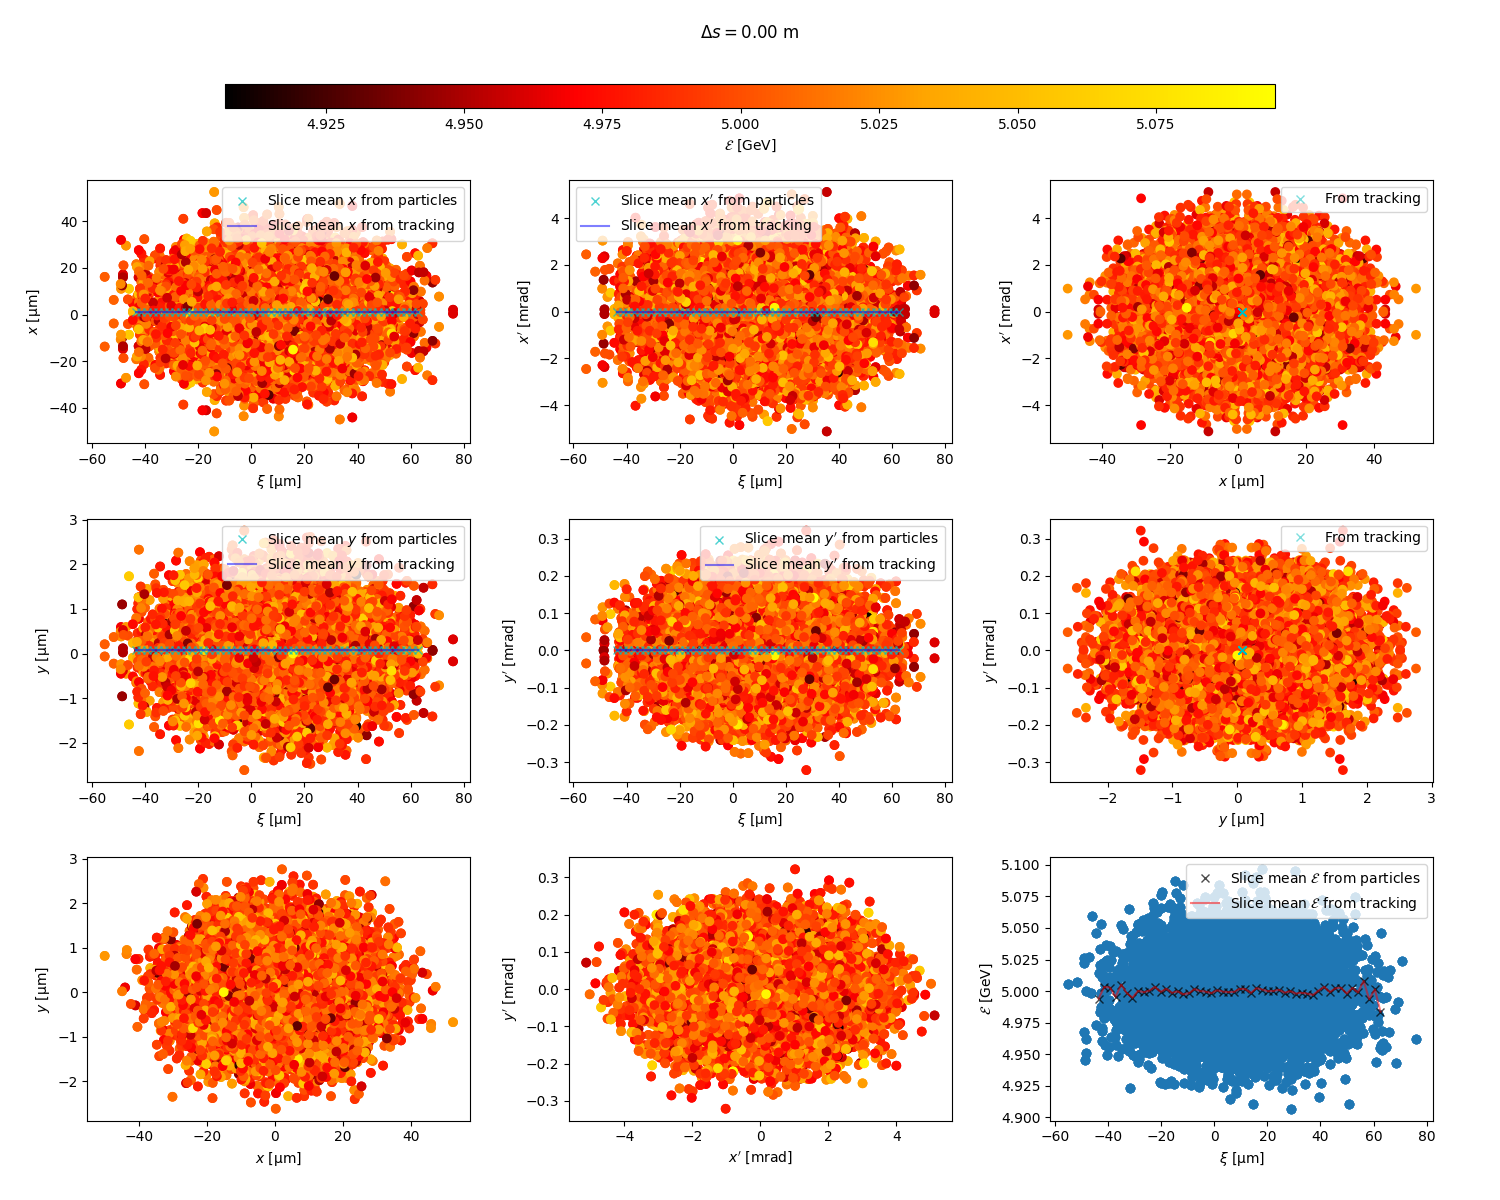

In [6]:
first_stage.scatter_diags(beam=first_stage.main_beam, plot_centroids=True, n_th_particle=2)

## Calculate input longitudinal field, plasma bubble radius and longitudinal number profile with Wake-T

In [7]:
# Define a Wake-T stage
stage_wakeT = StageWakeT()
stage_wakeT.driver_source = driver
k_beta = k_p(stage.plasma_density)/np.sqrt(2*min(main_beam.gamma(),drive_beam.gamma()/2))
lambda_betatron = (2*np.pi/k_beta)
stage_wakeT.length = lambda_betatron/10  # [m]
stage_wakeT.plasma_density = stage.plasma_density  # [m^-3]
stage_wakeT.box_min_z = -100.0e-6
stage_wakeT.box_max_z = 500.0e-6
#stage_wakeT.box_size_r = 240.5e-6
stage_wakeT.opmd_diag = True  # Set to True for saving simulation results.
stage_wakeT.diag_dir = stage.diag_path + 'wake_t'

# Run the Wake-T stage
beam_copy = copy.deepcopy(stage.main_beam)
beam_wakeT = stage_wakeT.track(beam_copy)

# Read the simulation data
path = stage_wakeT.diag_dir + path_sep + 'hdf5'
#path = upload_dir + 'stage_instability_tests' + path_sep + 'wake_t' + path_sep + 'hdf5' # Temporary override
ts = OpenPMDTimeSeries(path)

Plasma stage: 100%|█████████████████████████████████████████████| 0.005583/0.005583 m [00:00]


/Users/ben_c/Library/CloudStorage/OneDrive-UniversitetetiOslo/Software/opal_env/lib/python3.10/site-packages/aptools/data_analysis/beam_diagnostics.py:524: RuntimeWarning: invalid value encountered in sqrt
  em_x = np.sqrt(np.linalg.det(cov_x.astype(np.float32, copy=False)))


### Extract data

In [8]:
iteration = 0
time = ts.t[iteration]


# Extract macroparticle coordinates
xs_main, zs_main, weights_main = ts.get_particle(species='beam', iteration=iteration, var_list=['x', 'z', 'w'], plot=False)
xs_driver, zs_driver, weights_driver = ts.get_particle(species='driver', iteration=iteration, var_list=['x', 'z', 'w'], plot=False)
zs_beams = np.append(zs_driver, zs_main)
xs_beams = np.append(xs_driver, xs_main)


# Extract transverse fields
Ex, info_Ex = ts.get_field(field='E', coord='x', iteration=iteration, plot=False)
By, info_By = ts.get_field(field='B', coord='y', iteration=iteration, plot=False)
Ex_cBy = Ex - c*By
zs_Ex = info_Ex.z
rs_Ex = info_Ex.r


# Extract longitudinal E-field
Ez_wakeT, info_Ez = ts.get_field(field='E', coord='z', iteration=iteration, plot=False)
#dir(info_Ez)
zs_Ez_wakeT = info_Ez.z
rs_Ez = info_Ez.r
# Extract axial longitudinal E-field
Ez_axis_wakeT = Ez_wakeT[round(len(info_Ez.r)/2),:]


# Extract plasma charge density
rho, info_rho = ts.get_field(field='rho', iteration=iteration, plot=False)
# Calculate the number density
plasma_num_density = rho/stage_wakeT.plasma_density/-e
# Extract coordinates
zs_rho = info_rho.z
rs_rho = info_rho.r


# Extract the plasma bubble radius
bubble_radius_wakeT = stage.get_bubble_radius(plasma_num_density, rs_rho, threshold=0.8)


# Re-calculate number density profiles for the iteration
Nbins = int(np.sqrt(len(zs_driver)/2))
bins = np.linspace(np.min(zs_driver), np.max(zs_driver), Nbins)
counts, edges = np.histogram(zs_driver, weights=weights_driver*e, bins=bins)
zs_dNdz_driver_wakeT = (edges[0:-1] + edges[1:])/2
dNdz_driver_wakeT = counts/np.diff(edges)/e
xi_dNdz_driver_wakeT = zs_dNdz_driver_wakeT - c*time

Nbins = int(np.sqrt(len(zs_main)/2))
bins = np.linspace(np.min(zs_main), np.max(zs_main), Nbins)
counts, edges = np.histogram(zs_main, weights=weights_main, bins=bins)
zs_dNdz_main_wakeT = (edges[0:-1] + edges[1:])/2
dNdz_main_wakeT = counts/np.diff(edges)
xi_dNdz_main_wakeT = zs_dNdz_main_wakeT - c*time

### Make plots

Text(0, 0.5, '$\\partial N/\\partial z$ [$\\mathrm{m}^{-1}$]')

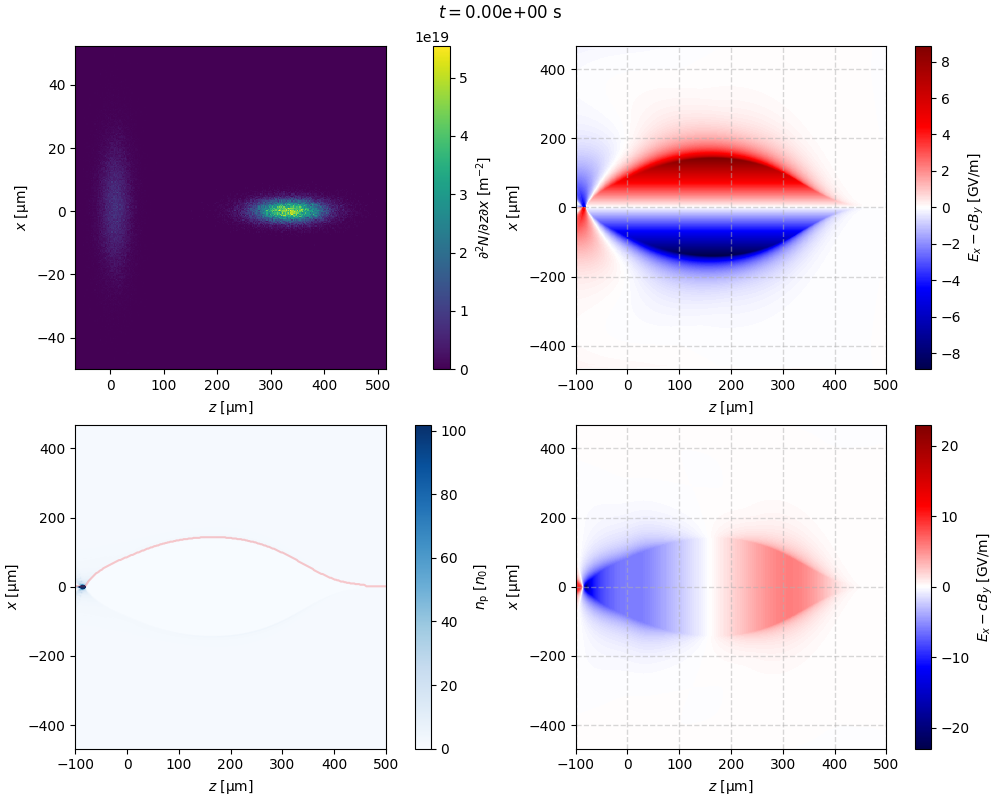

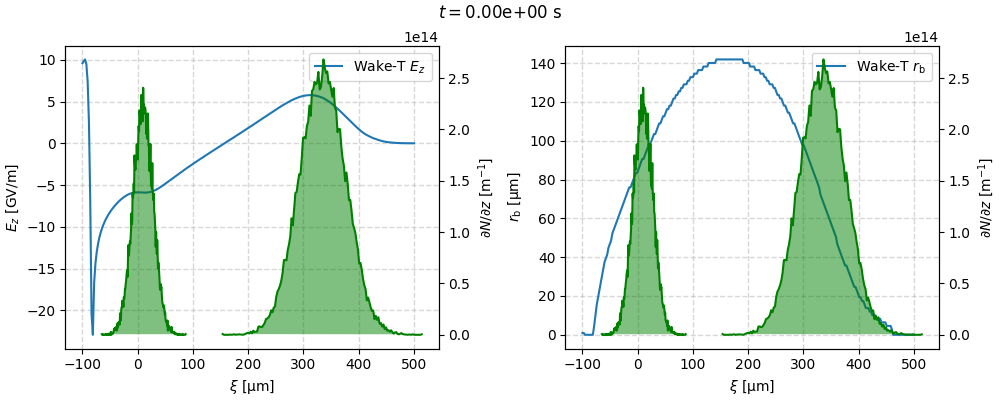

In [9]:
# Close all open figures
#plt.close('all')

# Get slider and figures (requires widget backend for interactive plots)
#ts.slider()

# Set up a figure with axes
fig_wakeT, axs_wakeT = plt.subplots(nrows=2, ncols=2, layout="constrained", figsize=(10, 4*2))
fig_wakeT.suptitle('$t=$' f'{format(time, ".2e")}' ' s')


# Plot the bunches
w = weights_driver
w = np.append(weights_driver, weights_main)  # The weights for the macroparticles. Append in same order as zs_beams.
nbins = int(np.sqrt(len(w)/2))
hist_bins = [ nbins, nbins ]  # list of 2 ints. Number of bins along each direction, for the histograms
hist_range = [[None, None], [None, None]]
hist_range[0] = [ zs_beams.min(), zs_beams.max() ]  # [m], list contains 2 lists of 2 floats. Extent of the histogram along each direction
hist_range[1] = [ xs_beams.min(), xs_beams.max() ]
extent = hist_range[0] + hist_range[1]
extent = [i*1e6 for i in extent]  # [um]
binned_data, zedges, xedges = np.histogram2d(zs_beams, xs_beams, hist_bins, hist_range, weights=w)
beam_hist2d = binned_data.T/np.diff(zedges)/np.diff(xedges); clab = '$\partial^2 N/\partial z\partial x$ [$\mathrm{m}^{-2}$]'
#beam_hist2d = binned_data.T; clab = '$N(z,x)$'
stage.imshow_plot(beam_hist2d, axes=axs_wakeT[0][0], extent=extent, vmin=None, vmax=None, colmap='viridis', 
                  xlab=zlab, ylab=xlab, clab=clab, gridOn=False, origin='lower', interpolation='nearest')


# Plot the transverse fields
extent = [zs_Ex.min(), zs_Ex.max(), rs_Ex.min(), rs_Ex.max()]
extent = [i*1e6 for i in extent]  # [um]
stage.imshow_plot(Ex_cBy/1e9, axes=axs_wakeT[0][1], extent=extent, vmin=Ex_cBy.min()/1e9, vmax=-Ex_cBy.min()/1e9, colmap='seismic', xlab=zlab, ylab=xlab, clab='$E_x-cB_y$ [GV/m]', gridOn=True, origin='lower')


# Plot the plasma number density
cmap_max = np.min(rho)/stage_wakeT.plasma_density/-e*0.0141
cmap_min = np.max(rho)/stage_wakeT.plasma_density/-e
rho_extent = [zs_rho.min(), zs_rho.max(), rs_rho.min(), rs_rho.max()]
rho_extent = [i*1e6 for i in rho_extent]  # [um]
stage.imshow_plot(plasma_num_density, axes=axs_wakeT[1][0], extent=rho_extent, vmin=cmap_min, vmax=cmap_max, colmap='Blues', xlab=zlab, ylab=xlab, clab='$n_\mathrm{p}$ [$n_0$]', gridOn=False, origin='lower')
axs_wakeT[1][0].plot(zs_rho*1e6, (bubble_radius_wakeT+main.x_offset)*1e6, 'r', alpha=0.2)


# Plot the longitudinal electric field
extent = [zs_Ez_wakeT.min(), zs_Ez_wakeT.max(), rs_Ez.min(), rs_Ez.max()]
extent = [i*1e6 for i in extent]  # [um]
stage.imshow_plot(Ez_wakeT/1e9, axes=axs_wakeT[1][1], extent=extent, vmin=Ez_wakeT.min()/1e9, vmax=-Ez_wakeT.min()/1e9, colmap='seismic', xlab=zlab, ylab=xlab, clab='$E_x-cB_y$ [GV/m]', gridOn=True, origin='lower')


# Set up a figure with axes
fig_wakeT2, axs_wakeT2 = plt.subplots(nrows=1, ncols=2, layout="compressed", figsize=(10, 4))
fig_wakeT2.suptitle('$t=$' f'{format(time, ".2e")}' ' s')


# Extract uploaded QuickPIC data for comparison
#QP_path =  upload_dir + '/2019-03-20_FACET-II_parameters_longSim_gamma195690_rb_Ez.csv'
#QP_dat = np.genfromtxt(QP_path, delimiter=',', skip_header=True)
#xi_rb_QP = QP_dat[:,0]
#rb_QP = QP_dat[:,1]
#xi_Ez_QP = QP_dat[:,2]
#Ez_QP = QP_dat[:,3]

# Plot longitudinal axial E-field
#axs_wakeT2[0].plot(xi_Ez_QP*1e6, Ez_QP/1e9, label='QuickPIC, $t=0$')
axs_wakeT2[0].plot((zs_Ez_wakeT-c*time)*1e6, Ez_axis_wakeT/1e9, label='Wake-T $E_z$')
axs_wakeT2[0].legend()
axs_wakeT2[0].grid(True, which='both', axis='both', linestyle='--', linewidth=1, alpha=.5)
axs_wakeT2[0].set_xlabel(xilab)
axs_wakeT2[0].set_ylabel(field_lab)
ax = axs_wakeT2[0].twinx()
ax.fill(xi_dNdz_main_wakeT*1e6, dNdz_main_wakeT, 'g', alpha=0.5)
ax.plot(xi_dNdz_main_wakeT*1e6, dNdz_main_wakeT, 'g')
ax.fill(xi_dNdz_driver_wakeT*1e6, dNdz_driver_wakeT, 'g', alpha=0.5)
ax.plot(xi_dNdz_driver_wakeT*1e6, dNdz_driver_wakeT, 'g')
ax.set_ylabel(dN_dz_lab)


# Plot the plasma bubble radius
#axs_wakeT2[1].plot(xi_rb_QP*1e6, rb_QP*1e6, label='QuickPIC, $t=0$')
axs_wakeT2[1].plot((zs_rho-c*time)*1e6, bubble_radius_wakeT*1e6, label='Wake-T $r_\mathrm{b}$')
axs_wakeT2[1].legend()
axs_wakeT2[1].grid(True, which='both', axis='both', linestyle='--', linewidth=1, alpha=.5)
axs_wakeT2[1].set_xlabel(xilab)
axs_wakeT2[1].set_ylabel('$r_\mathrm{b}$ [$\mathrm{\mu}$m]')
ax = axs_wakeT2[1].twinx()
ax.fill(xi_dNdz_main_wakeT*1e6, dNdz_main_wakeT, 'g', alpha=0.5)
ax.plot(xi_dNdz_main_wakeT*1e6, dNdz_main_wakeT, 'g')
ax.fill(xi_dNdz_driver_wakeT*1e6, dNdz_driver_wakeT, 'g', alpha=0.5)
ax.plot(xi_dNdz_driver_wakeT*1e6, dNdz_driver_wakeT, 'g')
ax.set_ylabel(dN_dz_lab)

#stage_wakeT.plot_evolution()
#beam_wakeT.plot_lps()



In [10]:
#test = np.sum(beam_hist2d*np.diff(xedges), axis=0)
#print(np.sum(test*np.diff(zedges)))
#
#plt.figure()
#plt.plot(zedges[0:-1]*1e6, test)
#plt.plot(xi_dNdz_main_wakeT*1e6, dNdz_main_wakeT, 'g', alpha=0.5)
#plt.plot(xi_dNdz_driver_wakeT*1e6, dNdz_driver_wakeT, 'g', alpha=0.5)
#
#
## Plot some transverse slices of the plasma number density
#plt.figure()
#rows, cols = np.shape(plasma_num_density)
##plt.plot(plasma_num_density[round(rows/2), 3:-1])
#idx_plasma_slice = round(cols/2)
#plt.plot(plasma_num_density[:,idx_plasma_slice], label='$z=$' f'{format(zs_rho[idx_plasma_slice]*1e6, ".1f")}' ' $\mathrm{\mu}$m')
#plt.plot(plasma_num_density[:,idx_plasma_slice+50], label='$z=$' f'{format(zs_rho[idx_plasma_slice+50]*1e6, ".1f")}' ' $\mathrm{\mu}$m')
#plt.plot(plasma_num_density[:,idx_plasma_slice+75], label='$z=$' f'{format(zs_rho[idx_plasma_slice+75]*1e6, ".1f")}' ' $\mathrm{\mu}$m')
#plt.plot(plasma_num_density[:,idx_plasma_slice+100], label='$z=$' f'{format(zs_rho[idx_plasma_slice+100]*1e6, ".1f")}' ' $\mathrm{\mu}$m')
#plt.plot(plasma_num_density[:,idx_plasma_slice-50], label='$z=$' f'{format(zs_rho[idx_plasma_slice-50]*1e6, ".1f")}' ' $\mathrm{\mu}$m')
#plt.plot(plasma_num_density[:,idx_plasma_slice-75], label='$z=$' f'{format(zs_rho[idx_plasma_slice-75]*1e6, ".1f")}' ' $\mathrm{\mu}$m')
#plt.plot(plasma_num_density[:,idx_plasma_slice-100], label='$z=$' f'{format(zs_rho[idx_plasma_slice-100]*1e6, ".1f")}' ' $\mathrm{\mu}$m')
#plt.plot(plasma_num_density[:,idx_plasma_slice-120], label='$z=$' f'{format(zs_rho[idx_plasma_slice-120]*1e6, ".1f")}' ' $\mathrm{\mu}$m')
#
#plt.grid(True, which='both', axis='both', linestyle='--', linewidth=1, alpha=.5)
#plt.xlabel('Index')
#plt.ylabel('$n_\mathrm{p}$ [$n_0$]')
#plt.title('$t=$' f'{format(time, ".2e")}' ' s')
#plt.legend()

## Perform tracking

In [11]:
linac.run(notebook_name, overwrite=overwrite)

Tracking element 1 (s = 0.0 m, -1.60 nC, 5.0 GeV, SourceBasic, stage 0)
Plasma stage: 100%|█████████████████████████████████████████████| 0.005583/0.005583 m [00:00]


/Users/ben_c/Library/CloudStorage/OneDrive-UniversitetetiOslo/ABEL/examples/../abel/classes/stage/impl/stage_slice_transverse_wake_instability.py:289: RuntimeWarning: invalid value encountered in divide
  xp_slices_start = ux_slices_after*uz_slices_before/ux_slices_before/uz_slices_after * xp_slices_start ################
/Users/ben_c/Library/CloudStorage/OneDrive-UniversitetetiOslo/ABEL/examples/../abel/classes/stage/impl/stage_slice_transverse_wake_instability.py:290: RuntimeWarning: invalid value encountered in divide
  yp_slices_start = uy_slices_after*uz_slices_before/uy_slices_before/uz_slices_after * yp_slices_start ################
/Users/ben_c/Library/CloudStorage/OneDrive-UniversitetetiOslo/ABEL/examples/../abel/classes/stage/impl/stage_slice_transverse_wake_instability.py:296: RuntimeWarning: invalid value encountered in divide
  xp_slices = ux_slices_after*uz_slices_before/ux_slices_before/uz_slices_after * xp_slices
/Users/ben_c/Library/CloudStorage/OneDrive-Universiteteti

Tracking element 2 (s = 2.5 m, -1.60 nC, 19.6 GeV, StageSlicesTransWakeInstability, stage 1)
Tracking element 3 (s = 9.4 m, -1.60 nC, 19.6 GeV, InterstageBasic, stage 1)
Plasma stage: 100%|█████████████████████████████████████████████| 0.009869/0.009869 m [00:00]
Tracking element 4 (s = 14.4 m, -1.60 nC, 49.7 GeV, StageSlicesTransWakeInstability, stage 2)
Tracking element 5 (s = 25.4 m, -1.60 nC, 49.7 GeV, InterstageBasic, stage 2)
Plasma stage: 100%|█████████████████████████████████████████████| 0.009869/0.009869 m [00:00]
Tracking element 6 (s = 30.4 m, -1.60 nC, 80.2 GeV, StageSlicesTransWakeInstability, stage 3)
Tracking element 7 (s = 44.2 m, -1.60 nC, 80.2 GeV, InterstageBasic, stage 3)
Plasma stage: 100%|█████████████████████████████████████████████| 0.009869/0.009869 m [00:00]
Tracking element 8 (s = 49.2 m, -1.60 nC, 111.0 GeV, StageSlicesTransWakeInstability, stage 4)
Tracking element 9 (s = 65.4 m, -1.60 nC, 111.0 GeV, InterstageBasic, stage 4)
Plasma stage: 100%|███████████

In [12]:
shot_num = 0
stage_num = 15
stage_tracked = linac[shot_num].stages[stage_num]  # Get a specific acceleration stage in a linac. Zero indexing.
beam_out = linac[shot_num].get_beam(stage_num*2+1)  # Get the corresponding beam after the acceleration stage. Zero indexing.
#beam_out = linac[shot_num].get_beam(-2)

## Plot outputs

### Cut-out bubble radius, longitudinal E-field and longitudinal beam profile

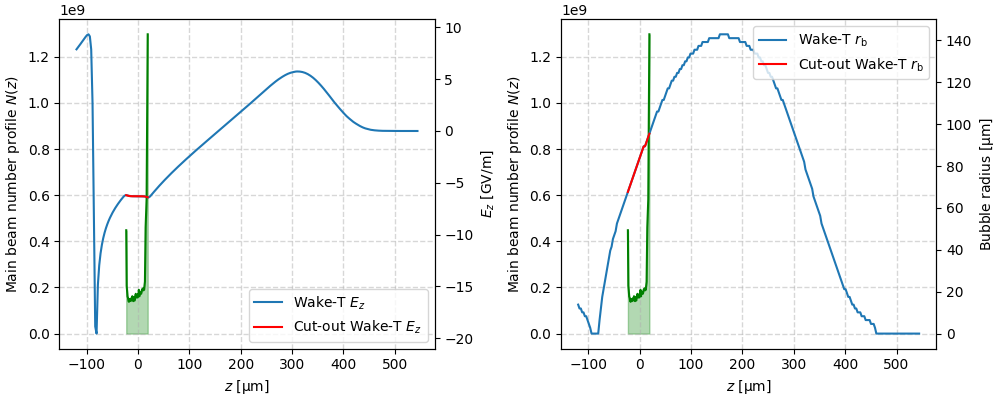

In [13]:
stage_tracked.plot_Ez_rb_cut()

### Beam slice plots

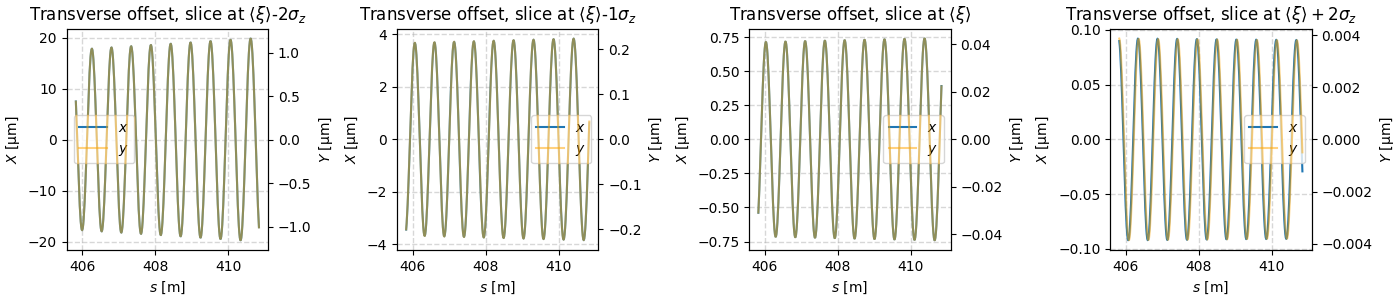

In [14]:
stage_tracked.slice_offset_s_diag(beam=beam_out)

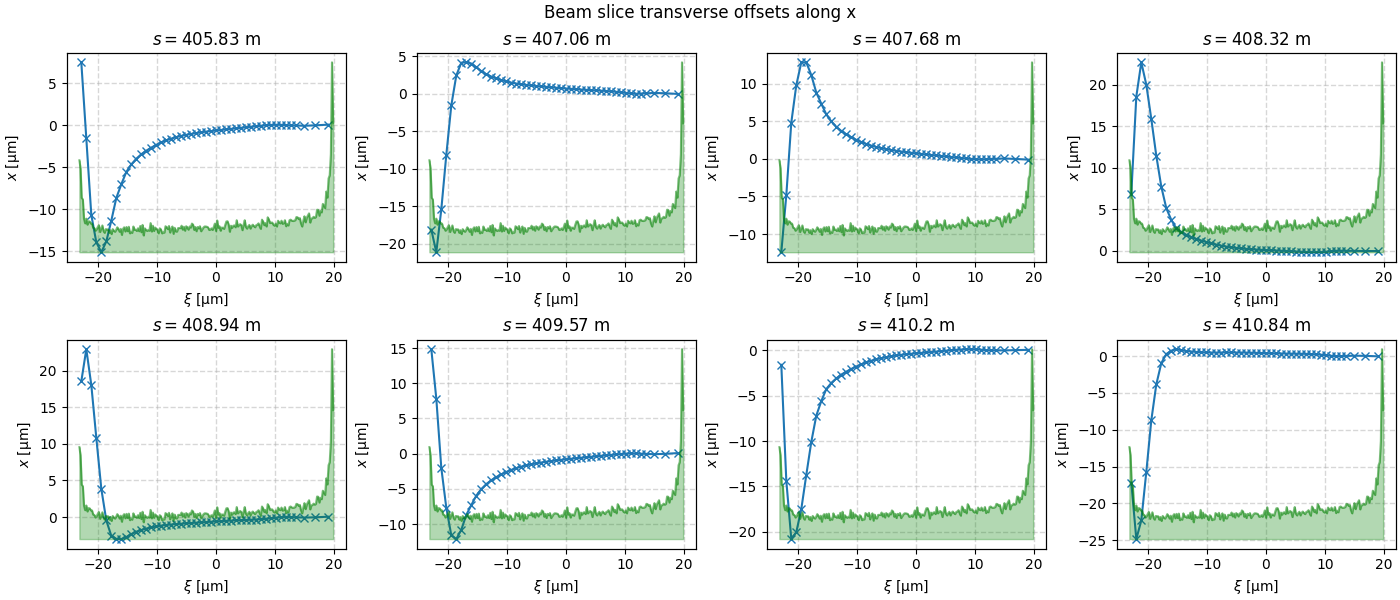

In [15]:
stage_tracked.centroid_snapshot_plots(beam=beam_out)

### Beam particle plots

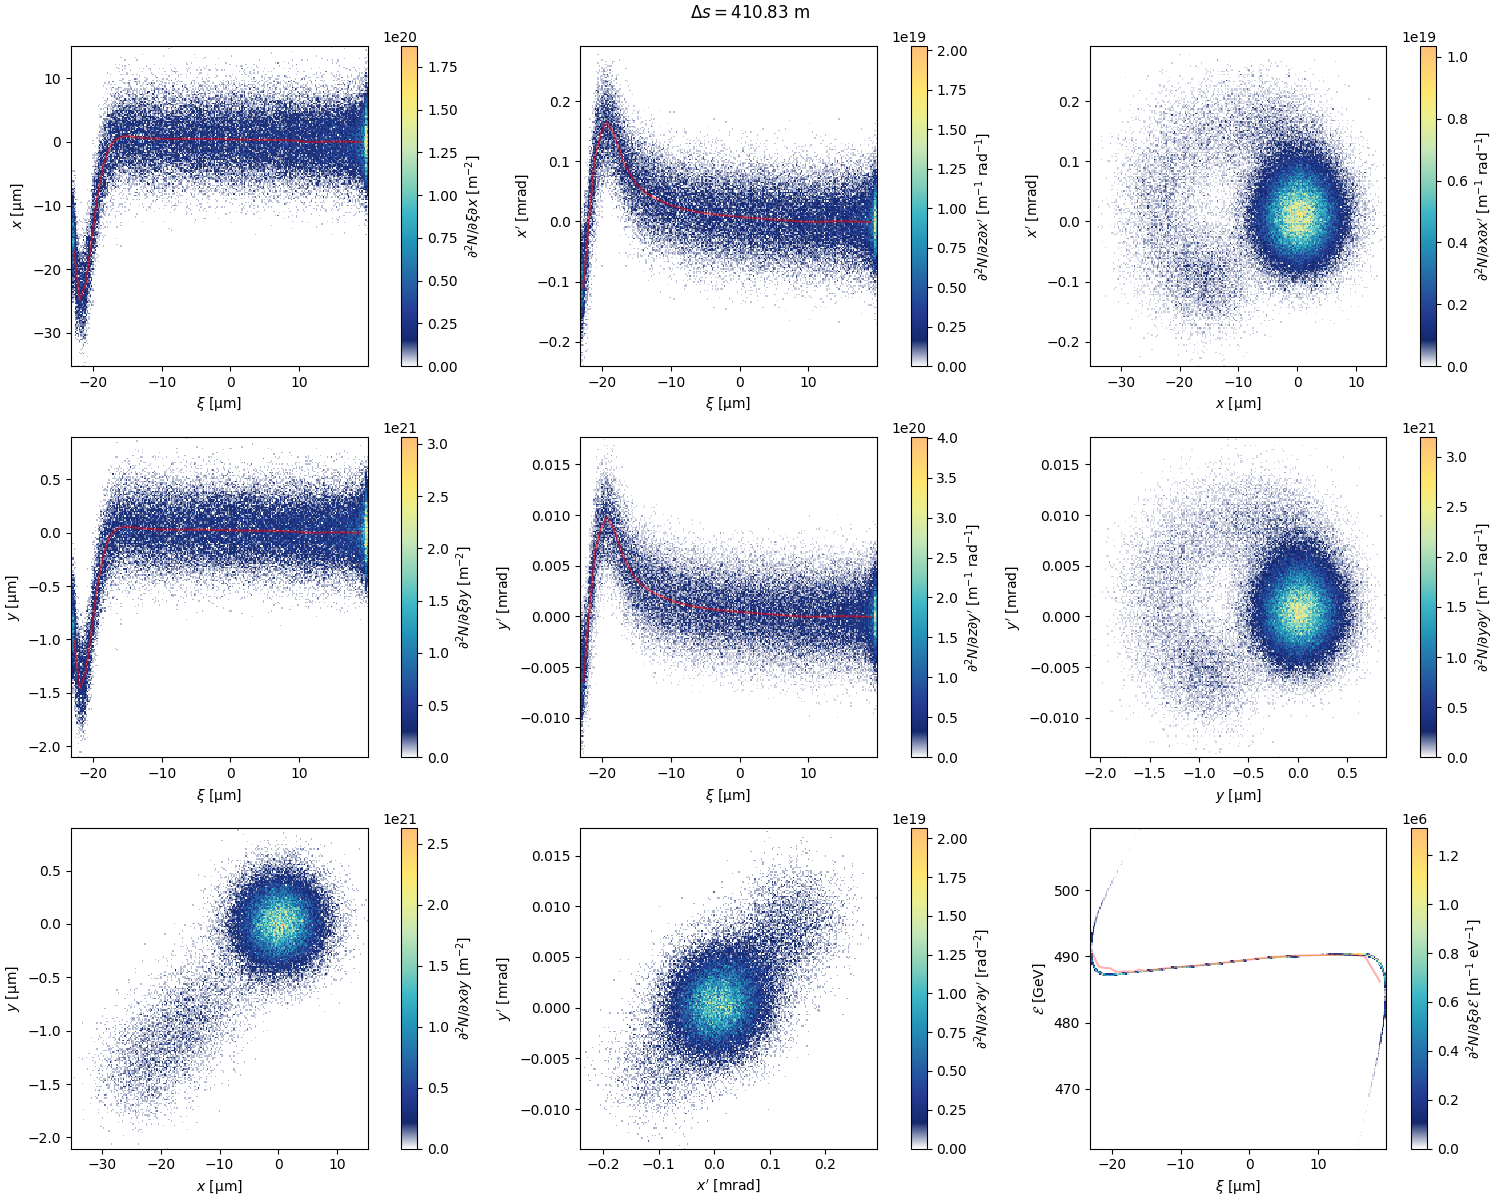

In [16]:
plot_stage = stage_tracked

# Set up override to plot other stages
#plot_stage = linac[shot_num].stages[1]  # Get a specific acceleration stage in a linac. Zero indexing.

plot_stage.density_map_diags(beam=beam_out, plot_centroids=True)

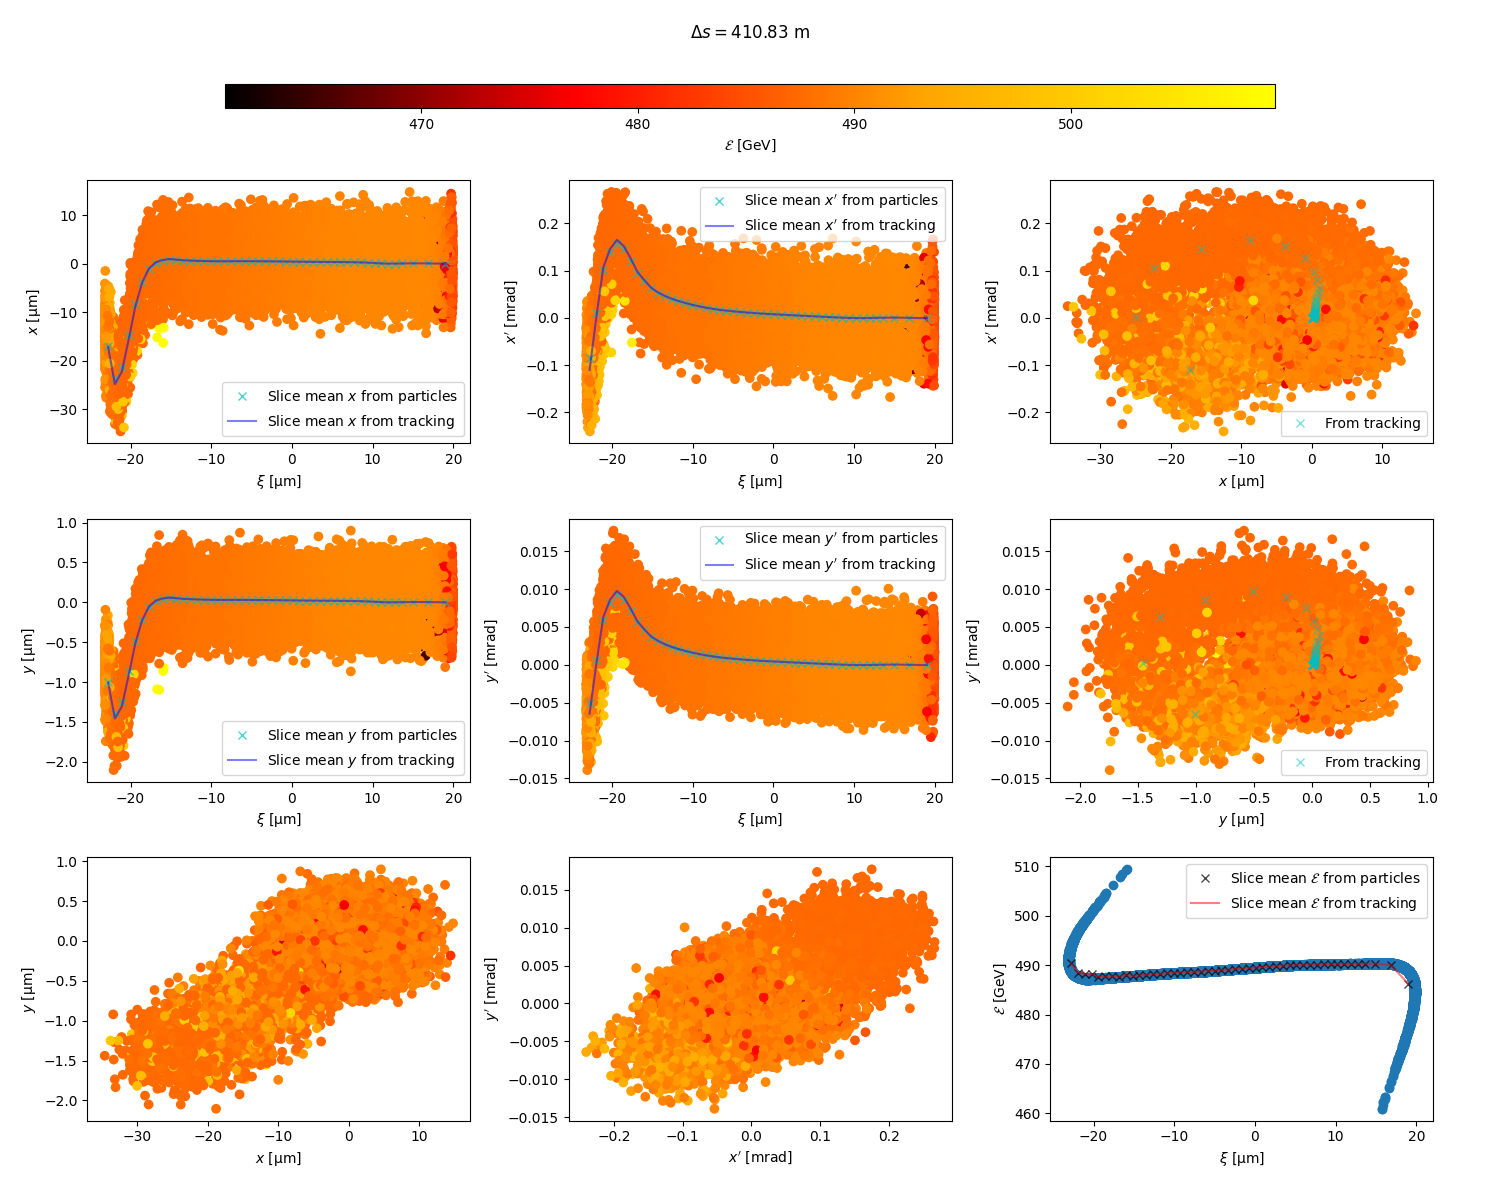

In [17]:
plot_stage = stage_tracked

# Set up override to plot other stages
#plot_stage = linac[shot_num].stages[1]  # Get a specific acceleration stage in a linac. Zero indexing.

plot_stage.scatter_diags(beam=beam_out, plot_centroids=True, n_th_particle=3, show_slice_grid=False, plot_k_beta=False)

## Plot beam evolution and survey

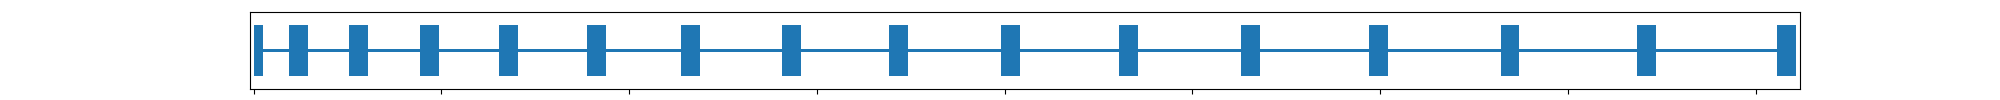

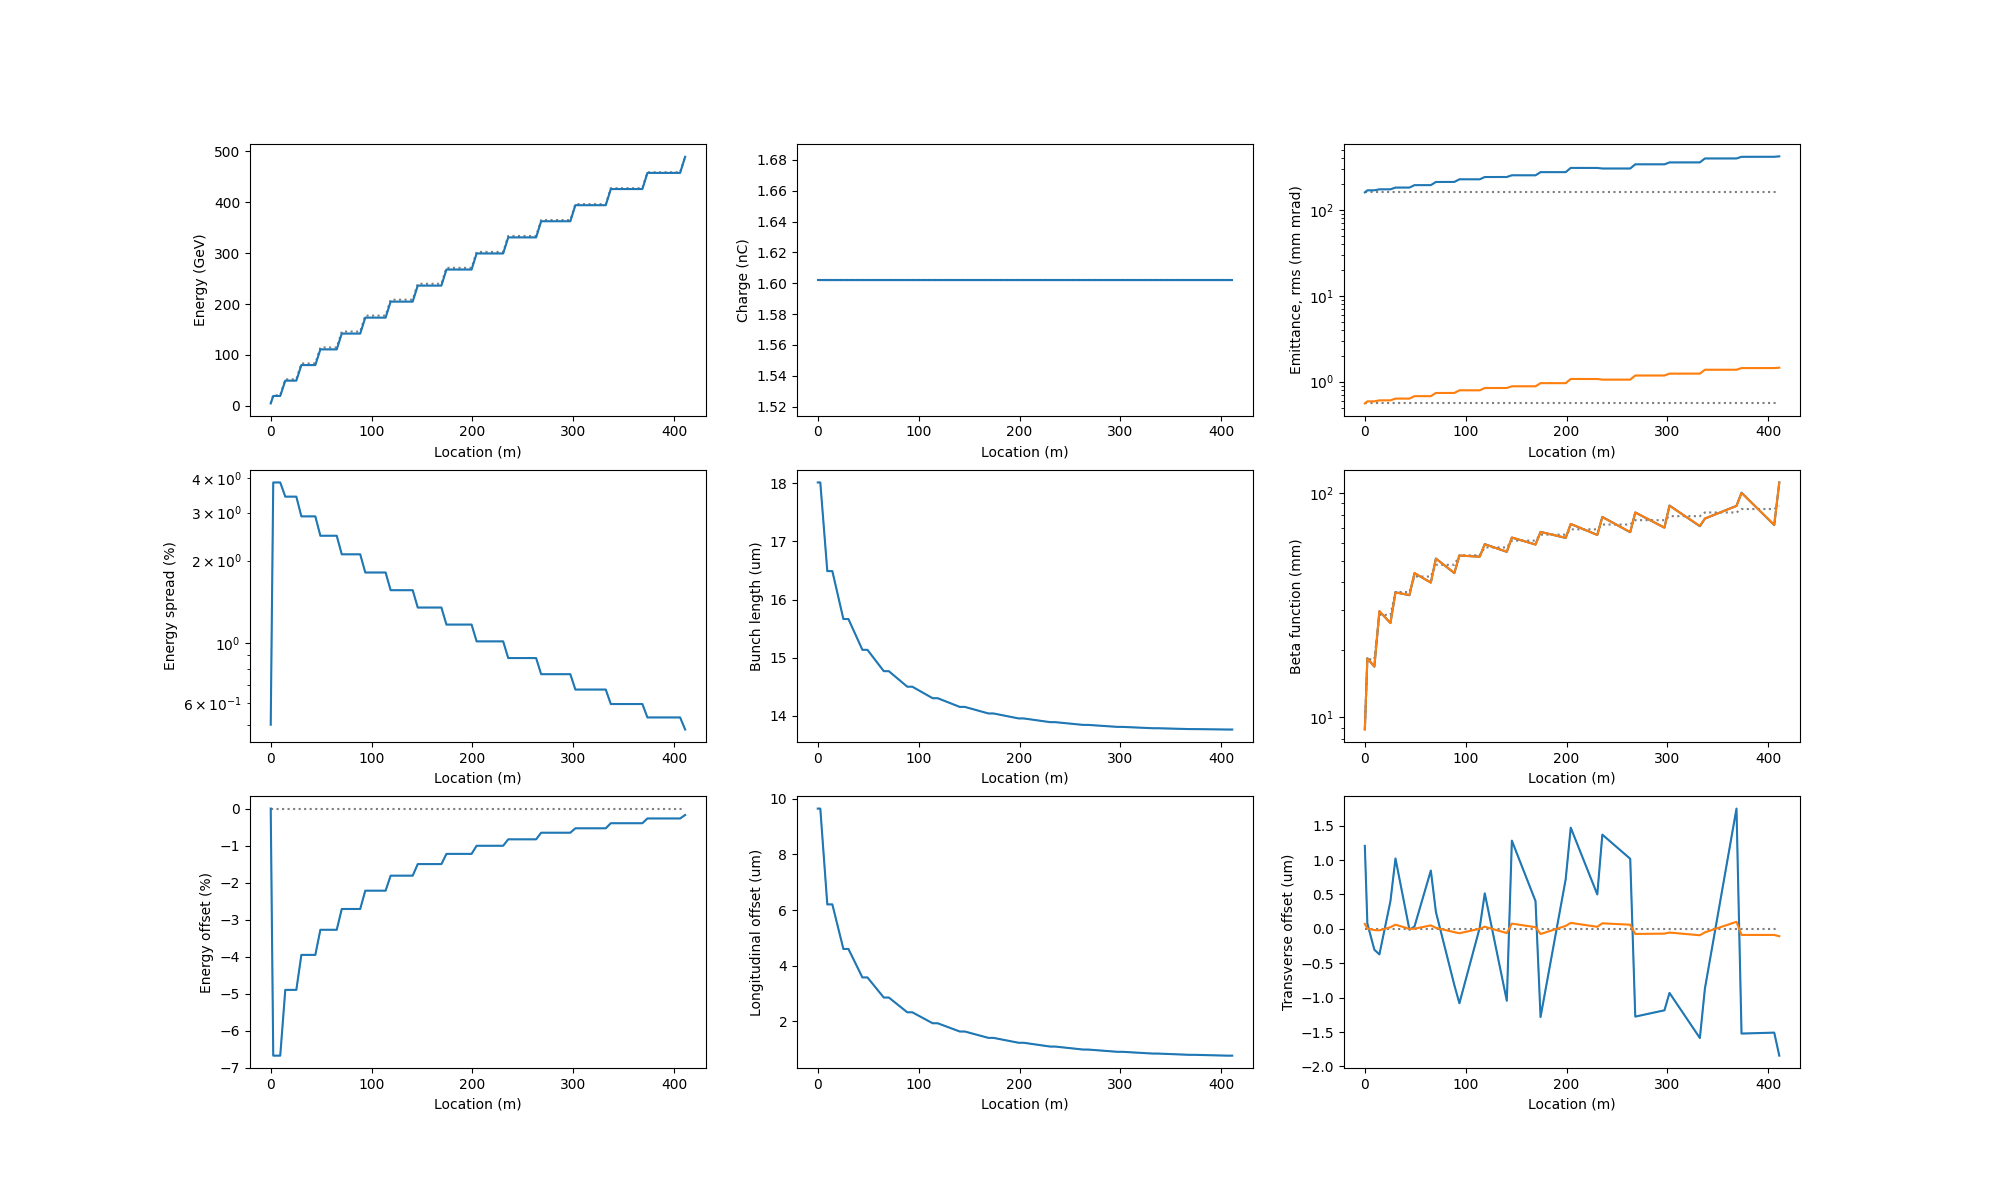

In [18]:
# plot linac survey
linac.plot_survey()

# plot beam evolution
linac.plot_evolution()

In [19]:
stage_tracked.print_current_summary(drive_beam, main_beam, beam_out)

Stage length [m]:					 5.000
Propagation length [m]:					 410.826
Plasma density [m^-3]:					 7.000e+21
Current mean gamma:					 956758.518
Current mean energy  [GeV]:				 488.903
Initial rms energy spread [%]:				 0.502
Current rms energy spread [%]:				 0.481

Current rms main beam length [um]:			 13.764
Initial rms main beam length [um]:			 18.067
Beam region of interest [sigma_z]:			 3.000
Beam slice thickness [um]:				 2.118
Number of beam slices:					 47
Initial number of beam particles:			 100000
Current number of beam particles:			 100000

Initial drive beam x offset [um]:			 -0.001
Initial drive beam y offset [um]:			 0.008
Initial drive beam z offset [um]:			 333.889

Initial main beam x offset [um]:			 1.205
Initial main beam y offset [um]:			 0.071
Initial main beam z offset [um]:			 9.607

Initial normalised x emittance [mm mrad]:		 160.637
Current normalised x emittance [mm mrad]:		 420.536
Initial normalised y emittance [mm mrad]:		 0.561
Current normalised y emittance [

## Scrap codes

In [20]:
crash this lol

# Close all open figures
#plt.close('all')

#z_slices = s_table[-1,:]
#x_slices = x_slice_table[-1,:]
#print(os.path.abspath('../abel/classes/stage/impl/stage_transverse_wake_instability.py'))
#%run ../abel/classes/stage/impl/stage_transverse_wake_instability.py


nbins = int(np.sqrt(len(weights_main)/2))
hist_bins = [ nbins, nbins ]  # list of 2 ints. Number of bins along each direction, for the histograms
hist_range = [[None, None], [None, None]]
hist_range[0] = [ xis_main_tracked.min(), xis_main_tracked.max() ]  # [m], list contains 2 lists of 2 floats. Extent of the histogram along each direction
hist_range[1] = [ xs_main_tracked.min(), xs_main_tracked.max() ]
extent = hist_range[0] + hist_range[1]
extent = [i*1e6 for i in extent]  # [um]


########## Before tracking ##########
# Set up a figure with axes
fig_start_beam, axs_start_beam = plt.subplots(nrows=2, ncols=2, layout='constrained', figsize=(10, 4*2))
fig_start_beam.suptitle('$\Delta s=$' f'{format(0.0, ".2f")}' ' m')

# 2D z-x distribution of initial beam
#hist_range_start = [[None, None], hist_range[1]]
#hist_range_start[0] = [ z0s_main.min(), z0s_main.max() ]  # [m], list contains 2 lists of 2 floats. Extent of the histogram along each direction
##hist_range_start[1] = [ x0s_main.min(), x0s_main.max() ]
#extent_start = hist_range_start[0] + hist_range_start[1]
#extent_start = [i*1e6 for i in extent]  # [um]
binned_data, zedges, xedges = np.histogram2d(z0s_main, x0s_main, hist_bins, hist_range, weights=main_beam.qs()/-e)
beam_hist2d = binned_data.T/np.diff(zedges)/np.diff(xedges); clab = '$\partial^2 N/\partial z\partial x$ [$\mathrm{m}^{-2}$]'
#beam_hist2d = binned_data.T; clab = '$N(z,x)$'
stage_tracked.imshow_plot(beam_hist2d, axes=axs_start_beam[0][0], extent=extent, vmin=None, vmax=None, colmap='viridis', 
                  xlab=xilab, ylab=xlab, clab=clab, gridOn=False, origin='lower', interpolation='nearest')
#axs_start_beam[0][0].plot((stage_tracked.zs_main_cut)*1e6, stage_tracked.particles2slices(beam=main_beam, beam_quant=main_beam.xs())*1e6, 'rx')
axs_start_beam[0][0].plot((stage_tracked.zs_main_cut)*1e6, first_stage.particles2slices(beam=main_beam, beam_quant=main_beam.xs(), z_slices=z0s_main_cut)*1e6, 'r')
axs_start_beam[0][0].axis(extent)

#stage_tracked.distribution_plot_2D(arr1=z0s_main, arr2=x0s_main, hist_bins=hist_bins, hist_range=hist_range, 
#                                   axes=axs_start_beam[0][0], extent=extent, vmin=None, vmax=None, colmap='viridis', 
#                                   xlab=xilab, ylab=xlab, clab=clab, origin='lower', interpolation='nearest')

# Scatter plot of initial beam
#axs_start_beam[0][1].scatter(z0s_main*1e6, x0s_main*1e6)
#axs_start_beam[0][1].axis(extent)
#axs_start_beam[0][1].set_xlabel(xilab)
#axs_start_beam[0][1].set_ylabel(xlab)


# 2D z-x' distribution
hist_range_xps = [[None, None], [None, None]]
hist_range_xps[0] = hist_range[0]
hist_range_xps[1] = [ xps_main_tracked.min(), xps_main_tracked.max() ]  # [rad]
binned_data, zedges, xedges = np.histogram2d(z0s_main, xp0s_main, hist_bins, hist_range_xps, weights=main_beam.qs()/-e)
beam_hist2d = binned_data.T/np.diff(zedges)/np.diff(xedges); clab = '$\partial^2 N/\partial z\partial x\'$ [$\mathrm{m}^{-1}$ $\mathrm{rad}^{-1}$]'
#beam_hist2d = binned_data.T; clab = '$N(z,x)$'
extent_xps = hist_range_xps[0] + hist_range_xps[1]
extent_xps[0] = extent_xps[0]*1e6  # [um]
extent_xps[1] = extent_xps[1]*1e6  # [um]
extent_xps[2] = extent_xps[2]*1e3  # [mrad]
extent_xps[3] = extent_xps[3]*1e3  # [mrad]
stage_tracked.imshow_plot(beam_hist2d, axes=axs_start_beam[0][1], extent=extent_xps, vmin=None, vmax=None, colmap='viridis', 
                  xlab=xilab, ylab=xps_lab, clab=clab, gridOn=False, origin='lower', interpolation='nearest')
axs_start_beam[0][1].plot((stage_tracked.zs_main_cut)*1e6, first_stage.particles2slices(beam=main_beam, beam_quant=main_beam.xps(), z_slices=z0s_main_cut)*1e3, 'r')
axs_start_beam[0][1].axis(extent_xps)


# 2D z-energy distribution
hist_range_energ = [[None, None], [None, None]]
hist_range_energ[0] = hist_range[0]
hist_range_energ[1] = [ E0s_main.min()*0.99, E0s_main.max()*1.01 ]  # [eV]
binned_data, zedges, xedges = np.histogram2d(z0s_main, E0s_main, hist_bins, hist_range_energ, weights=main_beam.qs()/-e)
beam_hist2d = binned_data.T/np.diff(zedges)/np.diff(xedges); clab = '$\partial^2 N/\partial z\partial\mathcal{E}$ [$\mathrm{m}^{-1}$ $\mathrm{eV}^{-1}$]'
#beam_hist2d = binned_data.T; clab = '$N(z,x)$'
extent_energ = hist_range_energ[0] + hist_range_energ[1]
extent_energ[0] = extent_energ[0]*1e6  # [um]
extent_energ[1] = extent_energ[1]*1e6  # [um]
extent_energ[2] = extent_energ[2]/1e9  # [GeV]
extent_energ[3] = extent_energ[3]/1e9  # [GeV]
stage_tracked.imshow_plot(beam_hist2d, axes=axs_start_beam[1][0], extent=extent_energ, vmin=None, vmax=None, colmap='viridis', 
                  xlab=xilab, ylab=energ_lab, clab=clab, gridOn=False, origin='lower', interpolation='nearest')
axs_start_beam[1][0].plot((stage_tracked.zs_main_cut)*1e6, first_stage.particles2slices(beam=main_beam, beam_quant=main_beam.Es(), z_slices=z0s_main_cut)/1e9, 'r')
axs_start_beam[1][0].axis(extent_energ)


#axs_start_beam[1][0].scatter(z0s_main*1e6, E0s_main/1e9)
#axs_start_beam[1][0].axis(extent_energ)
#axs_start_beam[1][0].set_xlabel(xilab)
#axs_start_beam[1][0].set_ylabel(energ_lab)

# 2D x-x' distribution
hist_range_xxp = [[None, None], [None, None]]
hist_range_xxp[0] = hist_range[1]
hist_range_xxp[1] = [ xps_main_tracked.min(), xps_main_tracked.max() ]  # [rad]
binned_data, zedges, xedges = np.histogram2d(x0s_main, xp0s_main, hist_bins, hist_range_xxp, weights=main_beam.qs()/-e)
beam_hist2d = binned_data.T/np.diff(zedges)/np.diff(xedges); clab = '$\partial^2 N/\partial x\partial x\'$ [$\mathrm{m}^{-1}$ $\mathrm{rad}^{-1}$]'
#beam_hist2d = binned_data.T; clab = '$N(z,x)$'
extent_xxp = hist_range_xxp[0] + hist_range_xxp[1]
extent_xxp[0] = extent_xxp[0]*1e6  # [um]
extent_xxp[1] = extent_xxp[1]*1e6  # [um]
extent_xxp[2] = extent_xxp[2]*1e3  # [mrad]
extent_xxp[3] = extent_xxp[3]*1e3  # [mrad]
stage_tracked.imshow_plot(beam_hist2d, axes=axs_start_beam[1][1], extent=extent_xxp, vmin=None, vmax=None, colmap='viridis', 
                  xlab=xlab, ylab=xps_lab, clab=clab, gridOn=False, origin='lower', interpolation='nearest')


########## After tracking ##########
# Set up a figure with axes
fig_out_beam, axs_out_beam = plt.subplots(nrows=4, ncols=2, layout='constrained', figsize=(10, 4*4))
fig_out_beam.suptitle('$\Delta s=$' f'{format(beam_out.location, ".2f")}' ' m')


# 2D z-x distribution
binned_data, zedges, xedges = np.histogram2d(xis_main_tracked, xs_main_tracked, hist_bins, hist_range, weights=weights_main)
beam_hist2d = binned_data.T/np.diff(zedges)/np.diff(xedges); clab = '$\partial^2 N/\partial z\partial x$ [$\mathrm{m}^{-2}$]'
#beam_hist2d = binned_data.T; clab = '$N(z,x)$'
stage_tracked.imshow_plot(beam_hist2d, axes=axs_out_beam[0][0], extent=extent, vmin=None, vmax=None, colmap='viridis', 
                  xlab=xilab, ylab=xlab, clab=clab, gridOn=False, origin='lower', interpolation='nearest')
axs_out_beam[0][0].plot((stage_tracked.zs_main_cut)*1e6, x_slices*1e6, 'r', alpha=0.5)
axs_out_beam[0][0].axis(extent)

# Scatter plot of z-x phase space
X_slices_from_beam = stage_tracked.particles2slices(beam=beam_out, beam_quant=beam_out.xs())
axs_out_beam[0][1].scatter(xis_main_tracked*1e6, xs_main_tracked*1e6)
axs_out_beam[0][1].plot((stage_tracked.zs_main_cut)*1e6, x_slices*1e6, 'r', label='Slice mean $x$ from tracking')
axs_out_beam[0][1].plot((stage_tracked.zs_main_cut)*1e6, X_slices_from_beam*1e6, 'kx', alpha=0.7, label='Slice mean $x$ from particles')
axs_out_beam[0][1].axis(extent)
axs_out_beam[0][1].set_xlabel(xilab)
axs_out_beam[0][1].set_ylabel(xlab)
axs_out_beam[0][1].legend(loc='upper right')


# 2D z-x' distribution
#hist_range_xps = [[None, None], [None, None]]
#hist_range_xps[0] = hist_range[0]
#hist_range_xps[1] = [ xps_main_tracked.min(), xps_main_tracked.max() ]  # [rad]
#extent_xps = hist_range[0] + hist_range_xps[1]
#extent_xps[0] = extent_xps[0]*1e6  # [um]
#extent_xps[1] = extent_xps[1]*1e6  # [um]
#extent_xps[2] = extent_xps[2]*1e3  # [mrad]
#extent_xps[3] = extent_xps[3]*1e3  # [mrad]
binned_data, zedges, xedges = np.histogram2d(xis_main_tracked, xps_main_tracked, hist_bins, hist_range_xps, weights=weights_main)
beam_hist2d = binned_data.T/np.diff(zedges)/np.diff(xedges); clab = '$\partial^2 N/\partial z\partial x\'$ [$\mathrm{m}^{-1}$ $\mathrm{rad}^{-1}$]'
#beam_hist2d = binned_data.T; clab = '$N(z,x)$'
stage_tracked.imshow_plot(beam_hist2d, axes=axs_out_beam[1][0], extent=extent_xps, vmin=None, vmax=None, colmap='viridis', 
                  xlab=xilab, ylab=xps_lab, clab=clab, gridOn=False, origin='lower', interpolation='nearest')
axs_out_beam[1][0].plot((stage_tracked.zs_main_cut)*1e6, xp_slices*1e3, 'r', alpha=0.5)
axs_out_beam[1][0].axis(extent_xps)


# Scatter plot of z-x' phase space
xp_slices_from_beam = stage_tracked.particles2slices(beam=beam_out, beam_quant=beam_out.xps())
axs_out_beam[1][1].scatter(xis_main_tracked*1e6, xps_main_tracked*1e3)
axs_out_beam[1][1].plot((stage_tracked.zs_main_cut)*1e6, xp_slices*1e3, 'r', label='Slice $x\'$ from tracking')
axs_out_beam[1][1].plot((stage_tracked.zs_main_cut)*1e6, xp_slices_from_beam*1e3, 'kx', alpha=0.7, label='Slice $x\'$ from particles')
axs_out_beam[1][1].axis(extent_xps)
axs_out_beam[1][1].set_xlabel(xilab)
axs_out_beam[1][1].set_ylabel(xps_lab)
axs_out_beam[1][1].legend(loc='upper right')


# 2D z-energy distribution
hist_range_energ = [[None, None], [None, None]]
hist_range_energ[0] = hist_range[0]
hist_range_energ[1] = [ Es_main_tracked.min(), Es_main_tracked.max() ]  # [eV]
binned_data, zedges, xedges = np.histogram2d(xis_main_tracked, Es_main_tracked, hist_bins, hist_range_energ, weights=weights_main)
beam_hist2d = binned_data.T/np.diff(zedges)/np.diff(xedges); clab = '$\partial^2 N/\partial z\partial\mathcal{E}$ [$\mathrm{m}^{-1}$ $\mathrm{eV}^{-1}$]'
#beam_hist2d = binned_data.T; clab = '$N(z,x)$'
extent_energ = hist_range_energ[0] + hist_range_energ[1]
extent_energ[0] = extent_energ[0]*1e6  # [um]
extent_energ[1] = extent_energ[1]*1e6  # [um]
extent_energ[2] = extent_energ[2]/1e9  # [GeV]
extent_energ[3] = extent_energ[3]/1e9  # [GeV]
stage_tracked.imshow_plot(beam_hist2d, axes=axs_out_beam[2][0], extent=extent_energ, vmin=None, vmax=None, colmap='viridis', 
                  xlab=xilab, ylab=energ_lab, clab=clab, gridOn=False, origin='lower', interpolation='nearest')
axs_out_beam[2][0].plot((stage_tracked.zs_main_cut)*1e6, energy_slices/1e9, 'r', alpha=0.3)
axs_out_beam[2][0].axis(extent_energ)


# Scatter plot of z-energy phase space
energy_slices_from_beam = stage_tracked.particles2slices(beam=beam_out, beam_quant=beam_out.Es())
axs_out_beam[2][1].scatter(xis_main_tracked*1e6, Es_main_tracked/1e9)
axs_out_beam[2][1].plot((stage_tracked.zs_main_cut)*1e6, energy_slices/1e9, 'r', label='Slice $\mathcal{E}$ from tracking')
axs_out_beam[2][1].plot((stage_tracked.zs_main_cut)*1e6, energy_slices_from_beam/1e9, 'kx', alpha=0.7, label='Slice $\mathcal{E}$ from particles')
axs_out_beam[2][1].axis(extent_energ)
axs_out_beam[2][1].set_xlabel(xilab)
axs_out_beam[2][1].set_ylabel(energ_lab)
axs_out_beam[2][1].legend(loc='upper right')


# 2D x-x' distribution
#hist_range_xxp = [[None, None], [None, None]]
#hist_range_xxp[0] = hist_range[1]
#hist_range_xxp[1] = [ xps_main_tracked.min(), xps_main_tracked.max() ]  # [rad]
binned_data, zedges, xedges = np.histogram2d(xs_main_tracked, xps_main_tracked, hist_bins, hist_range_xxp, weights=weights_main)
beam_hist2d = binned_data.T/np.diff(zedges)/np.diff(xedges); clab = '$\partial^2 N/\partial x\partial x\'$ [$\mathrm{m}^{-1}$ $\mathrm{rad}^{-1}$]'
#beam_hist2d = binned_data.T; clab = '$N(z,x)$'
#extent_xxp = hist_range_xxp[0] + hist_range_xxp[1]
#extent_xxp[0] = extent_xxp[0]*1e6  # [um]
#extent_xxp[1] = extent_xxp[1]*1e6  # [um]
#extent_xxp[2] = extent_xxp[2]*1e3  # [mrad]
#extent_xxp[3] = extent_xxp[3]*1e3  # [mrad]
stage_tracked.imshow_plot(beam_hist2d, axes=axs_out_beam[3][0], extent=extent_xxp, vmin=None, vmax=None, colmap='viridis', 
                  xlab=xlab, ylab=xps_lab, clab=clab, gridOn=False, origin='lower', interpolation='nearest')


# Scatter plot of x-x' phase space
axs_out_beam[3][1].scatter(xs_main_tracked*1e6, xps_main_tracked*1e3)
axs_out_beam[3][1].set_xlabel(xlab)
axs_out_beam[3][1].set_ylabel(xps_lab)
axs_out_beam[3][1].axis(extent_xxp)
axs_out_beam[3][1].set_xlabel(xlab)
axs_out_beam[3][1].set_ylabel(xps_lab)


#plt.figure()
#plt.scatter(z0s_main, main_beam.ys())
#
#plt.figure()
#plt.scatter(zs_main_tracked, main_beam.ys())

#plt.figure()
#plt.plot(z0s_main*1e6-zs_main_tracked*1e6)

#plt.figure()
#plt.plot(stage_tracked_tracked.zs_main_cut, stage_tracked.x_slices_main/main.x_offset)
#print(X_slices/main.x_offset)
#print(np.max(stage_tracked.main_beam.xs()))
#print(x0s_main.max())


#plt.figure()
#beam_out.plot_lps()
#beam_out.plot_trace_space_x()

# TODO: Compare this method of adding offsets to slices to QuickPIC. Do this for several time steps.

SyntaxError: invalid syntax (2963063228.py, line 1)

In [ ]:
# Beam slices data
s_slices_table = stage_tracked.s_slices_table_main
x_slices_table = stage_tracked.x_slices_table_main
xp_slices_table = stage_tracked.xp_slices_table_main
norm_amp_fac_s = stage_tracked.norm_amp_fac_s
mean_energy_s = stage_tracked.mean_energy_s
energy_spread_s = stage_tracked.energy_spread_s

z_slices = stage_tracked.zs_main_cut
x_slices = stage_tracked.x_slices_main
xp_slices = stage_tracked.xp_slices_main
energy_slices = stage_tracked.energy_slices_main
prop_dist = stage_tracked.prop_dist
#prop_dist = z_slices[-1] - z0s_main_cut[-1]

# Macro particles data
#zs_main_tracked = beam_out.zs()
#xis_main_tracked = zs_main_tracked
#xs_main_tracked = beam_out.xs()
#xps_main_tracked = beam_out.xps()
#Es_main_tracked = beam_out.Es()
#weights_main = beam_out.qs()/-e


# Find the corresponding offset data for comparison
ref_slice_sigma_z_min2 = -2.0
ref_slice_sigma_z_min1 = -1.0
ref_slice_sigma_z_0 = 0.0
ref_slice_sigma_z_2 = 2.0

slice_index_min2, _ = find_closest_value_in_arr(z_slices, np.mean(z_slices)+ref_slice_sigma_z_min2*beam_out.bunch_length())  # index n_sigma_z*sigma_z away from beam center towards tail. Lower index towards tail.
slice_index_min1, _ = find_closest_value_in_arr(z_slices, np.mean(z_slices)+ref_slice_sigma_z_min1*beam_out.bunch_length())
slice_index_0, _ = find_closest_value_in_arr(z_slices, np.mean(z_slices))
slice_index_2, _ = find_closest_value_in_arr(z_slices, np.mean(z_slices)+ref_slice_sigma_z_2*beam_out.bunch_length())

s_min2 = s_slices_table[:,slice_index_min2]
X_min2 = x_slices_table[:,slice_index_min2]
s_min1 = s_slices_table[:,slice_index_min1]
X_min1 = x_slices_table[:,slice_index_min1]
s_0 = s_slices_table[:,slice_index_0]
X_0 = x_slices_table[:,slice_index_0]
s_2 = s_slices_table[:,slice_index_2]
X_2 = x_slices_table[:,slice_index_2]

# Initial values
first_stage = linac[shot_num].stages[0]
s_min2_start = first_stage.s_slices_table_main[0,slice_index_min2]
X_min2_start = first_stage.x_slices_table_main[0,slice_index_min2]
s_min1_start = first_stage.s_slices_table_main[0,slice_index_min1]
X_min1_start = first_stage.x_slices_table_main[0,slice_index_min1]
s_0_start = first_stage.s_slices_table_main[0,slice_index_0]
X_0_start = first_stage.x_slices_table_main[0,slice_index_0]
s_2_start = first_stage.s_slices_table_main[0,slice_index_2]
X_2_start = first_stage.x_slices_table_main[0,slice_index_2]

stage_tracked.instability_plots(s_ref_slice=s_0, x_ref_slice=X_0, xp_ref_slice=xp_slices_table[:,slice_index_0])

In [ ]:
#stage.matched_beta_function(main.energy)
#beta_matched(stage.plasma_density, main.energy)
#len(z_slices)

#np.sqrt(main.emit_nx/energy2gamma(500e9)*main.beta_x)
np.sqrt(10e-6/energy2gamma(31.25e9)*main.beta_x)

print(np.std(main_beam.Es())/np.mean(main_beam.Es()))
print(main_beam.rel_energy_spread())

In [ ]:
indices = np.argsort(beam_out.zs())
zs= beam_out.zs()
zs_sorted = zs[indices]

_, Ez_fit = stage_tracked.Ez_shift_fit(stage_tracked.Ez_axial, stage_tracked.zs_Ez_axial, stage_tracked.zs_main_cut, beam_out)
plt.figure()
plt.plot(zs_sorted*1e6, Ez_fit(zs_sorted)/1e9)
plt.plot(stage_tracked.zs_main_cut*1e6, stage_tracked.Ez_roi/1e9, alpha=0.5)

_, rb_fit = stage_tracked.rb_shift_fit(stage_tracked.bubble_radius_axial, stage_tracked.zs_bubble_radius_axial, stage_tracked.zs_main_cut, beam_out)
plt.figure()
plt.plot(zs_sorted*1e6, rb_fit(zs_sorted)*1e6)
plt.plot(stage_tracked.zs_main_cut*1e6, stage_tracked.bubble_radius_roi*1e6, alpha=0.5)

In [ ]:
plt.figure()
N,E=beam_out.energy_spectrum()
N=N/-e
plt.plot(E/1e9,N)

#test = np.sum(N*np.ones(len(N))*(E[1]-E[0]), axis=0)
#print(np.sum(N))
#print((E[1]-E[0]))
#print(np.sum(test))

plt.figure()
N,z=beam_out.longitudinal_num_density()
N=N
plt.plot(z*1e6,N)

#test = np.sum(N*np.ones(len(N))*(z[1]-z[0]), axis=0)
#print(np.sum(test))

plt.figure()
N,E=beam_out.rel_energy_spectrum()
N=N/-e
plt.plot(E,N)
test = np.sum(N*np.ones(len(N))*(E[1]-E[0]), axis=0)
#print(np.sum(N))
#print((E[1]-E[0]))
print(np.sum(test))

In [ ]:
from joblib import Parallel, delayed

def func1(arg1, arg2, arg3):
    # Code for func1
    return arg1 + arg2 + arg3, list(range(arg1, arg3))

def func2(arg1, arg2):
    # Code for func2
    return arg1 * arg2, list(range(arg1, arg2))

#if __name__ == '__main__':
arg1 = 1
arg2 = 5
results = Parallel(n_jobs=2)([
    delayed(func1)(arg1, arg2, arg2+1),
    delayed(func2)(arg1, arg2)
])
result1, result2 = results[0]
result3, result4 = results[1]
print(result1, result2)
print(result3, result4)


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap  # For customising colour maps

#colors = ['white', 'black', 'darkblue', 'green', 'yellow']
colors = ['white', 'aquamarine', 'lightgreen', 'green']
bounds = [0, 0.2, 0.4, 0.8, 1]
cmap = LinearSegmentedColormap.from_list('my_cmap', colors, N=256)

# Use the new colormap
plt.figure()
plt.imshow(np.random.rand(10, 10), cmap=cmap)
plt.colorbar()
plt.show()